In [1]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import h5py
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, label_binarize

In [3]:
with h5py.File('/kaggle/input/bit-vehicle/bitvehicle_dataset.h5', 'r') as file:
    images = file['images'][:]
    labels = file['labels'][:]
    
print('Total number of images: ',len(images))
print('Total number of labels: ',len(labels))

Total number of images:  9850
Total number of labels:  9850


In [4]:
unique_classes, class_counts = np.unique(labels, return_counts=True)
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

Class b'Bus': 555 samples
Class b'Microbus': 860 samples
Class b'Minivan': 467 samples
Class b'SUV': 1372 samples
Class b'Sedan': 5776 samples
Class b'Truck': 820 samples


In [5]:
desired_size = (224, 224)

num_images = len(images)
resized_images = np.empty((num_images,) + desired_size + (3,), dtype=np.uint8)

for i, image in enumerate(images):
    resized_pil_image = Image.fromarray((image * 255).astype(np.uint8)).resize(desired_size)
    resized_images[i] = np.array(resized_pil_image)

In [6]:
def adjust_brightness(image, factor):
    image = image.astype(np.float32)
    augmented_image = image + factor
    augmented_image = np.clip(augmented_image, 0, 255)
    augmented_image = augmented_image.astype(np.uint8)
    return augmented_image

def flip_image(image, flip_code):
    return cv2.flip(image, flip_code)

def rotate_image(image, angle):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(image, M, (cols, rows))

def zoom_image(image, zoom_factor):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 0, zoom_factor)
    return cv2.warpAffine(image, M, (cols, rows))

def shift_image(image, dx, dy):
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    return cv2.warpAffine(image, M, (cols, rows))

augmented_images = []
augmented_labels = []

for img, label in zip(resized_images, labels):
    if label == b'Bus':
        augmented_img_brightness = adjust_brightness(img, 50)
        augmented_img_flip_horizontal = flip_image(img, 1)
        augmented_img_flip_vertical = flip_image(img, 0)
        augmented_img_rotate = rotate_image(img, 30)
        augmented_img_zoom = zoom_image(img, 1.2)
        augmented_img_shift = shift_image(img, 20, 20)
        augmented_images.extend([
            augmented_img_brightness,
            augmented_img_flip_horizontal,
            augmented_img_flip_vertical,
            augmented_img_rotate,
            augmented_img_zoom,
            augmented_img_shift,
        ])
        augmented_labels.extend([label] * 6)
    if label == b'Minivan':
        augmented_img_brightness = adjust_brightness(img, 50)
        augmented_img_flip_horizontal = flip_image(img, 1)
        augmented_img_flip_vertical = flip_image(img, 0)
        augmented_img_rotate = rotate_image(img, 30)
        augmented_img_zoom = zoom_image(img, 1.2)
        augmented_img_shift = shift_image(img, 20, 20)
        augmented_images.extend([
            augmented_img_brightness,
            augmented_img_flip_horizontal,
            augmented_img_flip_vertical,
            augmented_img_rotate,
            augmented_img_zoom,
            augmented_img_shift,
        ])
        augmented_labels.extend([label] * 6)
        
    if label == b'Microbus':
        augmented_img_flip_horizontal = flip_image(img, 1)
        augmented_img_flip_vertical = flip_image(img, 0)
        augmented_images.extend([
            augmented_img_flip_horizontal,
            augmented_img_flip_vertical,
        ])
        augmented_labels.extend([label] * 2)
    
    if label == b'SUV':
        augmented_img_rotate = rotate_image(img, 30)
        augmented_images.extend([
            augmented_img_rotate,
        ])
        augmented_labels.extend([label] * 1)
        
    if label == b'Truck':
        augmented_img_flip_horizontal = flip_image(img, 1)
        augmented_img_flip_vertical = flip_image(img, 0)
        augmented_img_rotate = rotate_image(img, 30)
        augmented_images.extend([
            augmented_img_flip_horizontal,
            augmented_img_flip_vertical,
            augmented_img_rotate,
        ])
        augmented_labels.extend([label] * 3)

    else:
        augmented_images.append(img)
        augmented_labels.append(label)
    
print('Total number of augmented images: ',len(augmented_images))
print('Total number of augmented labels: ',len(augmented_labels))

Total number of augmented images:  20714
Total number of augmented labels:  20714


In [7]:
unique_classes_aug, class_counts_aug = np.unique(augmented_labels, return_counts=True)
for class_label, count in zip(unique_classes_aug, class_counts_aug):
    print(f"Class {class_label}: {count} samples")

Class b'Bus': 3885 samples
Class b'Microbus': 2580 samples
Class b'Minivan': 3269 samples
Class b'SUV': 2744 samples
Class b'Sedan': 5776 samples
Class b'Truck': 2460 samples


In [8]:
num_classes = len(np.unique(augmented_labels))
print('Number of classes',num_classes)

Number of classes 6


In [9]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(augmented_labels)
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print(label_mapping)
label = torch.tensor(encoded_labels)
labels = nn.functional.one_hot(label, num_classes=num_classes)
labels = labels.float()

{0: b'Bus', 1: b'Microbus', 2: b'Minivan', 3: b'SUV', 4: b'Sedan', 5: b'Truck'}


In [10]:
class ImageDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        if self.transform:
            x = self.transform(x)

        return x, y
transform = transforms.Compose([

    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


dataset = ImageDataset(np.array(augmented_images), labels, transform=transform)

In [11]:
model = models.googlenet(pretrained=True)
num_input_features = model.fc.in_features

model.fc = nn.Linear(num_input_features, num_classes)

use_cuda = torch.cuda.is_available()

if use_cuda:
    model.cuda()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 196MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
learning_rate = 0.0001
epochs = 3
batch_size = 32
k = 3

kf = KFold(n_splits=k, shuffle=True)
accuracy_values = []
weighted_precision_values = []
weighted_recall_values = []
weighted_f1_score_values = []


all_true_labels = []
all_pred_labels = []
confusion_matrices = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for fold, (train_index, test_index) in enumerate(kf.split(dataset), 1):
    print("Fold:", fold)
    train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_index)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          print(f"\rEpoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}", end='')

        print(f"\rEpoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

    model.eval()
    y_true = []
    y_pred = []

    for batch_idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = F.softmax(outputs, dim=1)

        y_true.extend(labels.cpu().tolist())
        y_pred.extend(predicted.cpu().tolist())

    print(f"\rEvaluation: Batch {batch_idx+1}/{len(test_loader)}", end='\n')
    
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    report = classification_report(y_true_labels, y_pred_labels, output_dict=True)

    confusion_matrices.append(cm)
    accuracy_values.append(report['accuracy'])
    weighted_precision_values.append(report['weighted avg']['precision'])
    weighted_recall_values.append(report['weighted avg']['recall'])
    weighted_f1_score_values.append(report['weighted avg']['f1-score'])
    
    all_true_labels.extend(y_true_labels)
    all_pred_labels.extend(y_pred)


avg_accuracy = np.mean(accuracy_values)
avg_weighted_precision = np.mean(weighted_precision_values)
avg_weighted_recall = np.mean(weighted_recall_values)
weighted_f1_score_values = np.mean(weighted_f1_score_values)

print('Average accuracy:', avg_accuracy)
print('Average weighted precision:', avg_weighted_precision)
print('Average weighted recall:', avg_weighted_recall)
print('Average weighted f1_score:', weighted_f1_score_values)

Fold: 1
Epoch 1/3, Loss: 0.30252, Loss: 0.0130
Epoch 2/3, Loss: 0.06312, Loss: 0.0767
Epoch 3/3, Loss: 0.02682, Loss: 0.0055
Evaluation: Batch 216/216
Fold: 2
Epoch 1/3, Loss: 0.05632, Loss: 0.0162
Epoch 2/3, Loss: 0.01952, Loss: 0.0796
Epoch 3/3, Loss: 0.00932, Loss: 0.0870
Evaluation: Batch 216/216
Fold: 3
Epoch 1/3, Loss: 0.01722, Loss: 0.0308
Epoch 2/3, Loss: 0.00762, Loss: 0.0036
Epoch 3/3, Loss: 0.01302, Loss: 0.0153
Evaluation: Batch 216/216
Average accuracy: 0.9913105745384653
Average weighted precision: 0.9913910099460366
Average weighted recall: 0.9913105745384653
Average weighted f1_score: 0.9913249208723977


In [13]:
all_pred_labels = np.array(all_pred_labels)
all_true_labels = np.array(all_true_labels)
n_classes = len(np.unique(all_true_labels))
all_true_labels_binarized = label_binarize(all_true_labels, classes=range(n_classes))
true = all_true_labels_binarized.ravel()
pred = all_pred_labels.ravel()

In [14]:
roc_values = pd.DataFrame({
    'True_Class': true,
    'Pred_Class': pred,
})

model = 'GoogLeNet'
dataset = 'BIT-Vehicle'

roc_values.to_csv(f'/kaggle/working/{dataset}_{model}_ROC.csv', index=False)

In [15]:
learning_curves = pd.DataFrame({
    'Precision': weighted_precision_values,
    'Recall': weighted_recall_values,
    'F1_score': weighted_f1_score_values,
})

model = 'GoogLeNet'
dataset = 'BIT-Vehicle'

learning_curves.to_csv(f'/kaggle/working/{dataset}_{model}_Learning.csv', index=False)

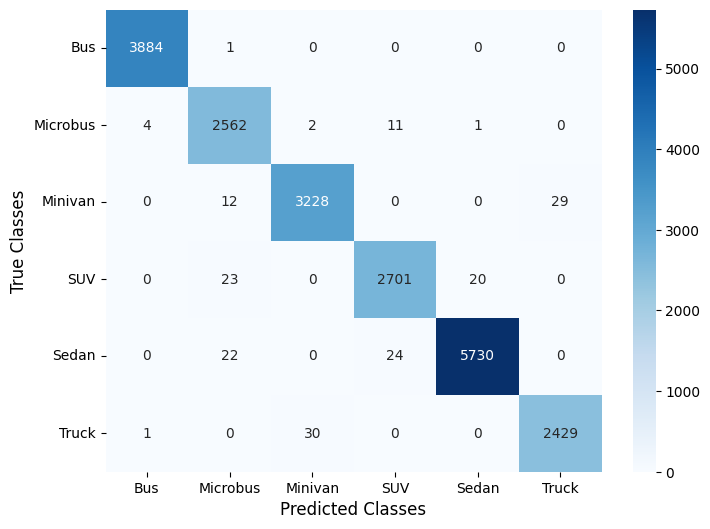

In [16]:
model = 'GoogLeNet'
dataset = 'BIT-Vehicle'

combined_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for fold, cm in enumerate(confusion_matrices, 1):
    combined_conf_matrix += cm

conf_matrix_labels = [label_mapping[i] for i in range(len(label_mapping))]
conf_matrix_labels = [label.decode('utf-8')[0:] for label in conf_matrix_labels]

num_labels = len(conf_matrix_labels)
fig_width = min(max(8, num_labels * 0.5), 12)
fig_height = max(6, num_labels * 0.4)

plt.figure(figsize=(fig_width, fig_height))
plt.rcParams['figure.dpi'] = 300

sns.heatmap(combined_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix_labels, yticklabels=conf_matrix_labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("True Classes", fontsize=12)
plt.savefig(f'/kaggle/working/confusion_matrix1-{dataset}_{model}.png', dpi=300, bbox_inches='tight')
plt.show()

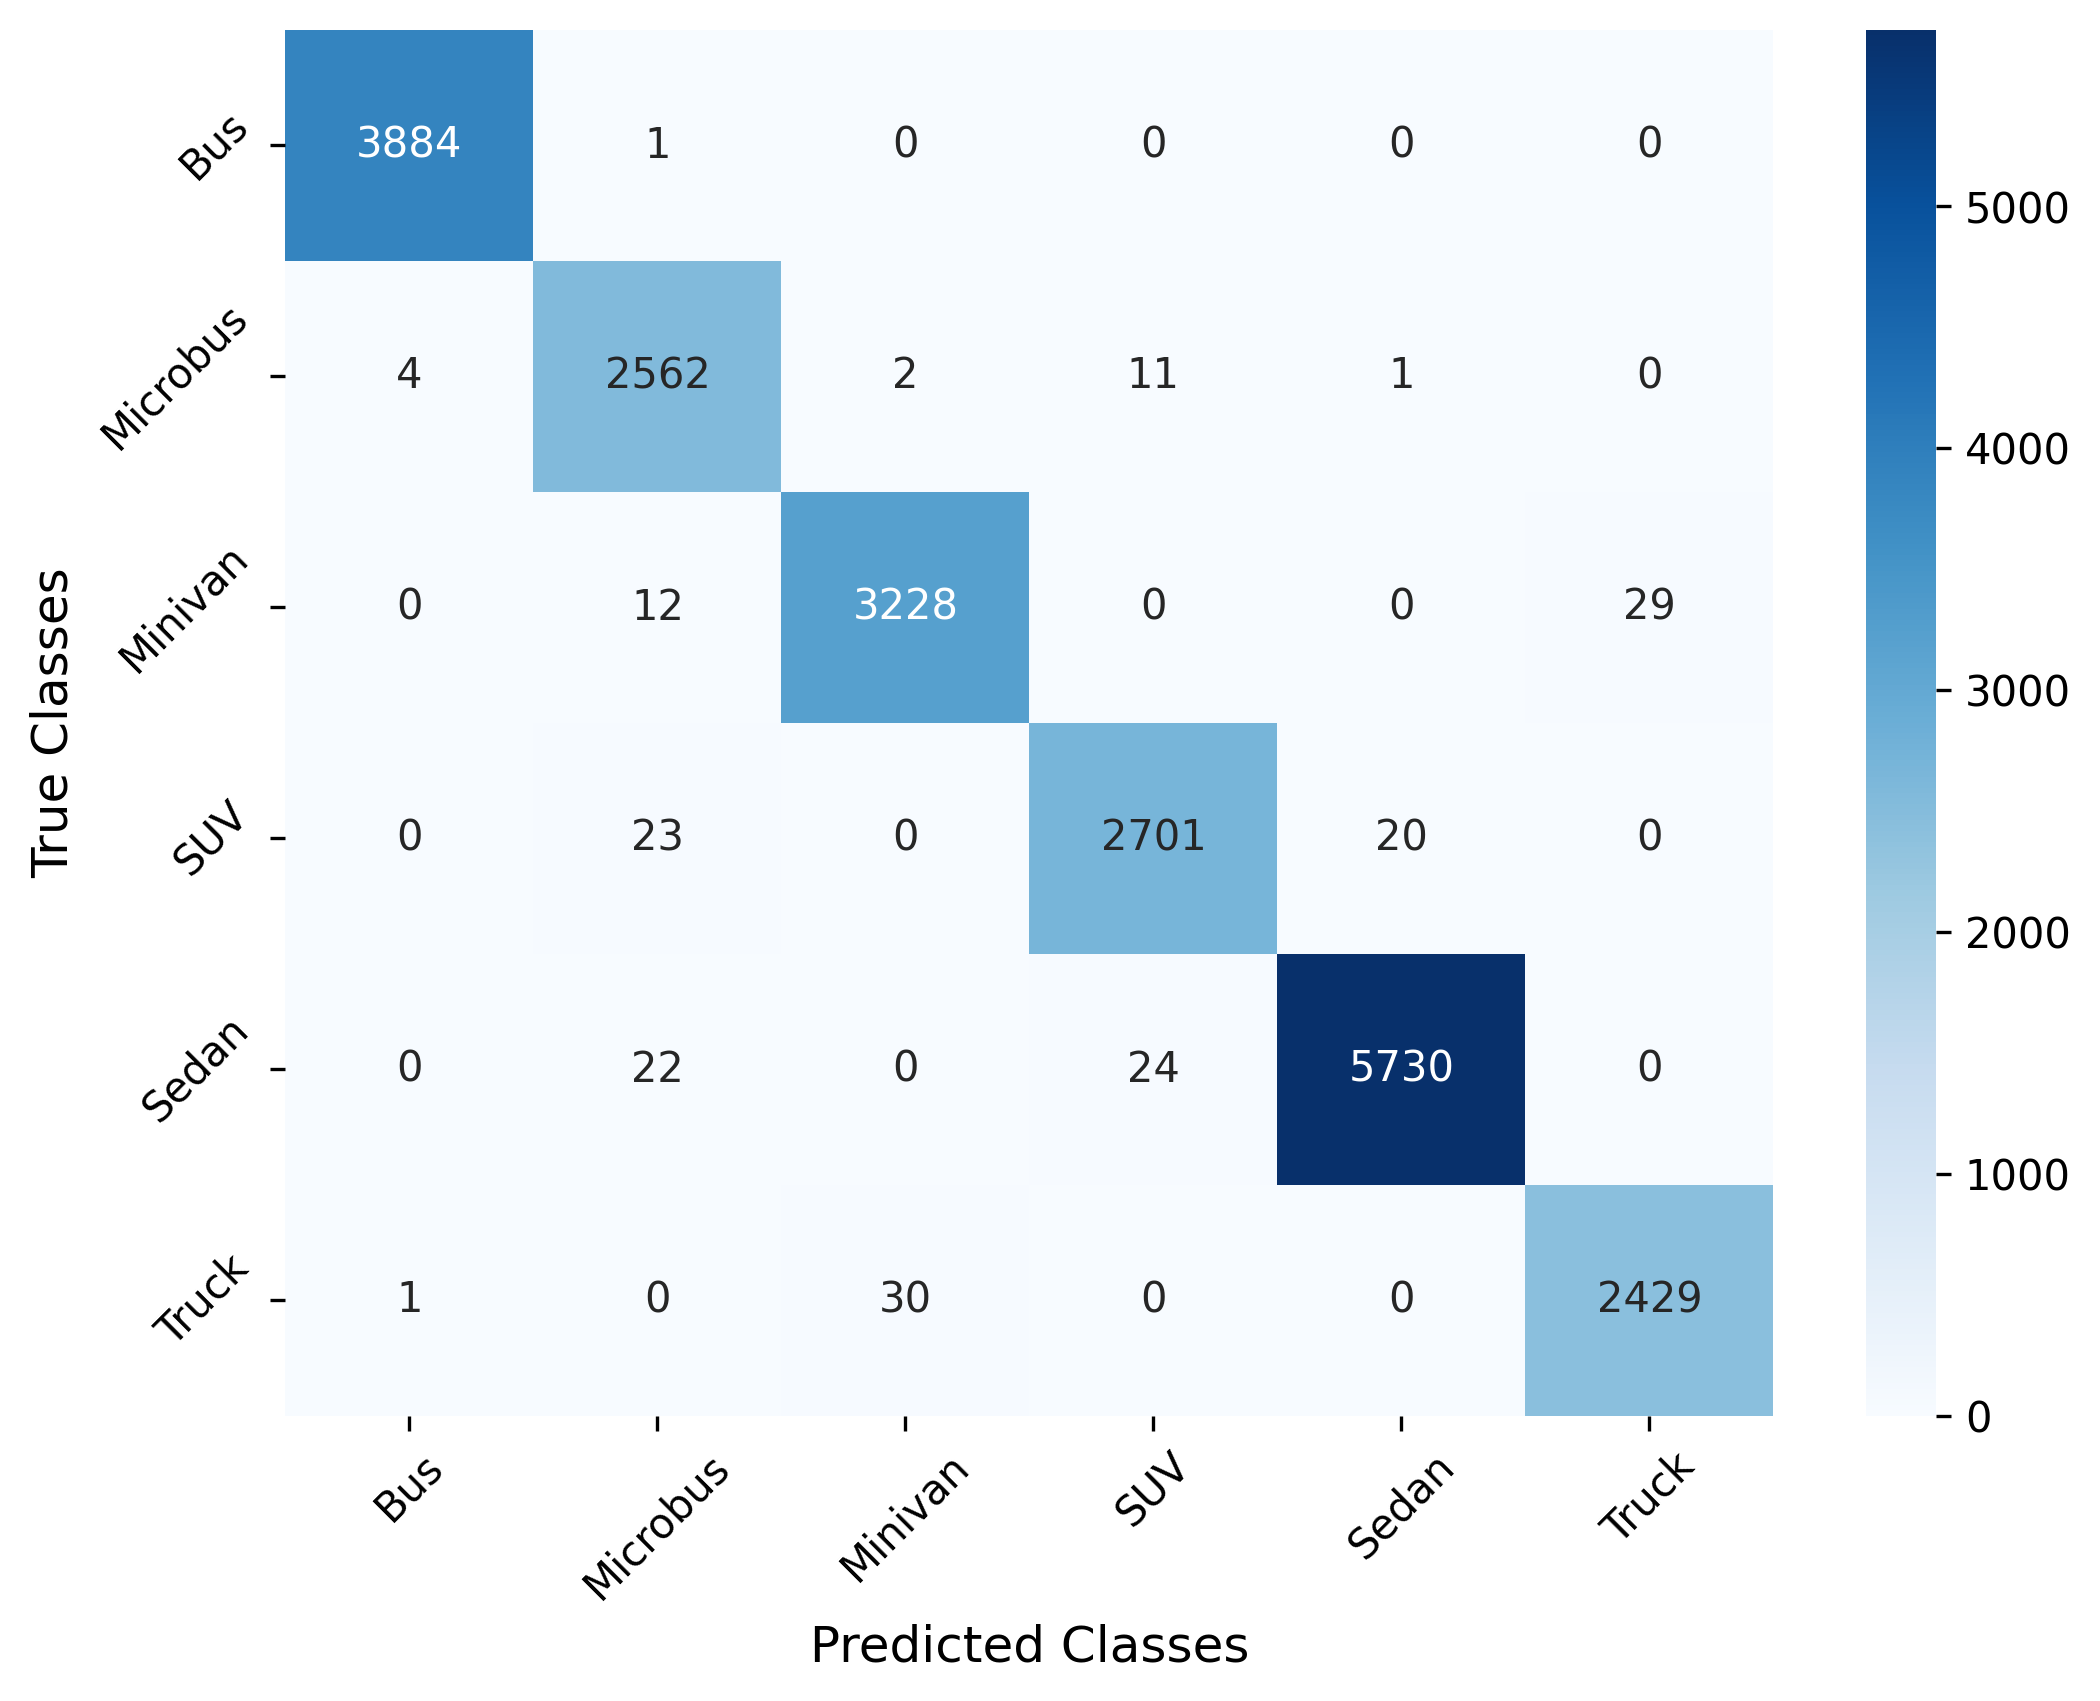

In [17]:
model = 'GoogLeNet'
dataset = 'BIT-Vehicle'

conf_matrix_labels = [label_mapping[i] for i in range(len(label_mapping))]
conf_matrix_labels = [label.decode('utf-8')[0:] for label in conf_matrix_labels]

num_labels = len(conf_matrix_labels)
fig_width = min(max(8, num_labels * 0.5), 12)
fig_height = max(6, num_labels * 0.4)

plt.figure(figsize=(fig_width, fig_height))
plt.rcParams['figure.dpi'] = 300

sns.heatmap(combined_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix_labels, yticklabels=conf_matrix_labels)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=45, fontsize=10)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("True Classes", fontsize=12)
plt.savefig(f'/kaggle/working/confusion_matrix2-{dataset}_{model}.png', dpi=300, bbox_inches='tight')
plt.show()